# Machine Learnig Models 
### by: Sanchana Mohankumar

# Problem Statement:
In this notebook we are implementing 3 Machine Learning Models Support Vector Machine, Logistic Regression, Descision Tree and checking for better performing models using the following metrics to detect whether the posted tweet is real or fake
*   Accuracy
*   F1-Score
*   Precision
*   Recall






# Installations

In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 5.4 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=b29dd9c632e9a0abc84ebdbf6d3f3c94022530e62ec31770338d9a45ace81f6d
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7452ac7d8d83b1930f8a6205c3c9649b24e80f9029fc38
Successfully built emoji


# Libraries

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd

from joblib import dump, load
import itertools

import matplotlib.pyplot as plt                                                      # Visulaization library
import seaborn as sns                                                                # Visulaization library

import re                                                                            # Regular expression
custom_punc = ',“”"!#$%&\'()*+-\./:;<=>?@[\\]^_`{|}~—ー‘’•–'                         # Removes these punctuations
from emoji import demojize                                                           # Removes Emoji
from gensim.parsing.preprocessing import remove_stopwords                            # Removing Stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer        # Word Embedding Techniques
from sklearn.metrics import classification_report, confusion_matrix                  # Performance Metrics 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score  # Performance Metrics
from sklearn.pipeline import Pipeline                                                

from sklearn import tree                                                             # Exporting Decision Tree Model
from sklearn.svm import SVC, LinearSVC                                               # Exporting SVM Models                             
from sklearn.linear_model import LogisticRegression                                  # Exporting Logistic Regression Models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV                               # Exporting RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Uploading Data
As we can see below we are exporting covid19 tweet train, valid and test data for further analysis

### Training Dataset

In [ ]:
#Load the tweet training set
covid_train = pd.read_csv("/content/drive/MyDrive/Covid_data_fake_news/Constraint_Train.csv") 
covid_train.head(2)

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real


### Validation Dataset

In [ ]:
#Load the tweet validation set
covid_valid = pd.read_csv("/content/drive/MyDrive/Covid_data_fake_news/Constraint_Val.csv") 
covid_valid.head(2)

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake


### Test Dataset

In [ ]:
#Load the tweet test set
covid_test_labelled = pd.read_csv("/content/drive/MyDrive/Covid_data_fake_news/english_test_with_labels.csv") 
covid_test_labelled.head(2)

,id,tweet,label
0,1,Our daily update is published. States reported...,real
1,2,Alfalfa is the only cure for COVID-19.,fake


##Preprocessing Tweet
- In the below step we are performing Text preprocessing for tweet column of all training, validation and test data.
- Further we have also displayed the result of preprocessed text in column clean text for all train, valid and test data using the function cleantext_preprocess


In [ ]:
def cleantext_preprocess(text):
        """ Text Preprocessing
        
        Returns:
        List of sentences containing words in each sentence with respect to each 
        tweet after performing each preprocesing steps
        """
        text = text.lower()                                    # Lowercase text
        text = re.sub(r"https?://\S+", "", text)               # Remove hyperlinks
        text = re.sub(r"\b[0-9]+\b\s*", "",text)               # Remove numbers
        text = text.replace("…", "")                           # Add space next to dots
        text = demojize(text)                                  # Removes emoji
        text = re.sub(r"(?<=\w)-(?=\w)", " ", text)            # Replace dash between words
        text = re.sub(f"[{re.escape(custom_punc)}]", "", text) # Removes punctuation using custom list
        text = text.replace('\uFFFD','')                       # Remove unicode �
        text = remove_stopwords(text)                          # Remove stopwords using genism parsing preprocessing
        text = " ".join(text.split())                          # Remove extra spaces, tabs, and new lines
        
        return text

In [ ]:
# Train data
covid_train['clean_text'] = covid_train['tweet'].apply(cleantext_preprocess)
covid_train.head(2)

,id,tweet,label,clean_text
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently reports deaths general discrepan...
1,2,States reported 1121 deaths a small rise from ...,real,states reported deaths small rise tuesday sout...


In [ ]:
# Validation data
covid_valid['clean_text'] = covid_valid['tweet'].apply(cleantext_preprocess)
covid_valid.head(2)

,id,tweet,label,clean_text
0,1,Chinese converting to Islam after realising th...,fake,chinese converting islam realising muslim affe...
1,2,11 out of 13 people (from the Diamond Princess...,fake,people diamond princess cruise ship intially t...


In [ ]:
# Test data
covid_test_labelled['clean_text'] = covid_test_labelled['tweet'].apply(cleantext_preprocess)
covid_test_labelled.head(2)

,id,tweet,label,clean_text
0,1,Our daily update is published. States reported...,real,daily update published states reported 734k te...
1,2,Alfalfa is the only cure for COVID-19.,fake,alfalfa cure covid


## Encoding column Label
As we know the dataset contains label column with Fake and real we are now converting into 0's and 1's we now replace the categorical value with a numeric value. We are applying this for Train, Validation and Test data

*   Fake as 0 
*   Real as 1


In [ ]:
# Train data
covid_train['encoded_label'] = covid_train['label'].replace(['fake','real'],[0, 1])
covid_train.head(2)

,id,tweet,label,clean_text,encoded_label
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently reports deaths general discrepan...,1
1,2,States reported 1121 deaths a small rise from ...,real,states reported deaths small rise tuesday sout...,1


In [ ]:
# Validation data
covid_valid['encoded_label'] = covid_valid['label'].replace(['fake','real'],[0, 1])
covid_valid.head(2)

,id,tweet,label,clean_text,encoded_label
0,1,Chinese converting to Islam after realising th...,fake,chinese converting islam realising muslim affe...,0
1,2,11 out of 13 people (from the Diamond Princess...,fake,people diamond princess cruise ship intially t...,0


In [ ]:
# Test data 
covid_test_labelled['encoded_label'] = covid_test_labelled['label'].replace(['fake','real'],[0, 1])
covid_test_labelled.head(2)

,id,tweet,label,clean_text,encoded_label
0,1,Our daily update is published. States reported...,real,daily update published states reported 734k te...,1
1,2,Alfalfa is the only cure for COVID-19.,fake,alfalfa cure covid,0


### Function to display confusion matrix 
Confusion matrices represent counts from predicted and actual values. The output “TN” stands for True Negative which shows the number of negative examples classified accurately. Similarly, “TP” stands for True Positive which indicates the number of positive examples classified accurately. The term “FP” shows False Positive value, i.e., the number of actual negative examples classified as positive; and “FN” means a False Negative value which is the number of actual positive examples classified as negative.

In [ ]:
def plot_confusion_matrix(cf_matrix, title):
      # Confusion matrix labels
      group_names = ['True Neg','False Pos','False Neg','True Pos']
      
      group_counts = ["{0:0.0f}".format(value) for value in
                     cf_matrix.flatten()]

      group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
      # combining all labels
      labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                    zip(group_names,group_counts,group_percentages)]

      labels = np.asarray(labels).reshape(2,2)
      ## Passing confusion matrix in sns plot
      ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

      ## Setting title, xlabel, ylabel
      ax.set_title(title);
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values ');

      ## Ticket labels - List must be in alphabetical order
      ax.xaxis.set_ticklabels(['Fake','Real'])
      ax.yaxis.set_ticklabels(['Fake','Real'])

      ## Displays the visualization of the Confusion Matrix.
      plt.show()


### Function to display classification report
It is one of the performance evaluation metrics of a classification-based machine learning model. It displays your model’s precision, recall, F1 score and support. It provides a better understanding of the overall performance of our trained model.


In [ ]:
def print_metrices(pred,true):
    print(classification_report(true,pred,))
    print('------------------------------------------------------')
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

# Implementing Tf-IDF word embedding technique on Machine learning Model

- We are implementing SVM, Decision Tree and Logistic Regression Model to train our fakenews dataset
- Count Vectorizer: https://www.educative.io/answers/countvectorizer-in-python
- TF- IDF         : https://www.educative.io/answers/what-is-tf-idf

# SVM (Support Vector Machine)

In the below pipeline we are passing Count Vectorizer and TF-idf vectorizer for performing Linear SVM Model 

In [ ]:
# We are passing countvectorizer and tfidf followed by SVM model in the pipeline
svm_pipeline = Pipeline([
        ('Count_vectorizer', CountVectorizer()),  # Count Vectorizer
        ('tfidf_vectorizer', TfidfTransformer()), # Tf-idf Vectorizer
        ('svm', LinearSVC())
    ])

Please find the explanation for below code 

Model Linear SVM
Validation Results:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1020
           1       0.94      0.93      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140

------------------------------------------------------
Accuracy :  0.930841121495327
Precison :  0.9309284438074296
Recall :  0.930841121495327
F1 :  0.9308187988903247
------------------------------------------------------


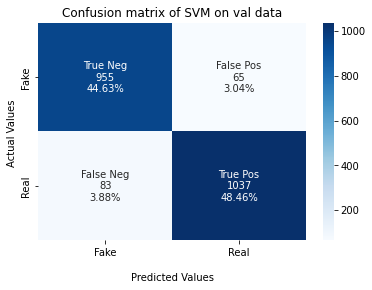

In [ ]:
# SVM pipeline is fit on covid train preprocessed data 
fit = svm_pipeline.fit(covid_train.clean_text, covid_train.encoded_label)
# Printing Model name and Validation results label
print('Model Linear SVM')
print ('Validation Results:')
# Predicting using validation data by the trained model 
pred = svm_pipeline.predict(covid_valid.clean_text)

# Calling classification report function print_metrics
print_metrices(pred, covid_valid.encoded_label)
print('------------------------------------------------------')
# confusion_matrix 
cf_matrix = confusion_matrix(covid_valid.encoded_label,pred)
# Calling confusion matrix using function plot_confusion_matrix
plot_confusion_matrix(cf_matrix, title = 'Confusion matrix of SVM on val data')

Model Linear SVM
Test Results:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1020
           1       0.95      0.91      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140

------------------------------------------------------
Accuracy :  0.9289719626168225
Precison :  0.9296825178669599
Recall :  0.9289719626168225
F1 :  0.9289337206282232
------------------------------------------------------


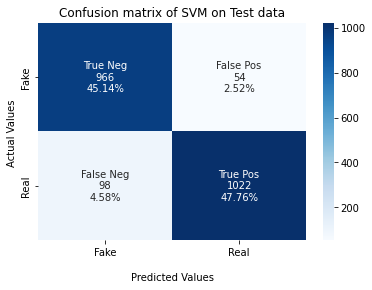

In [ ]:
# SVM pipeline is fit on covid train preprocessed data 
fit = svm_pipeline.fit(covid_train.clean_text, covid_train.encoded_label)
# Printing Model name and Test results label
print('Model Linear SVM')
print ('Test Results:')

# Predicting using test data by the trained model 
pred = svm_pipeline.predict(covid_test_labelled.tweet)

# Calling classification report function print_metrics
print_metrices(pred, covid_test_labelled.encoded_label)
print('------------------------------------------------------')

# confusion_matrix 
cf_matrix = confusion_matrix(covid_test_labelled.encoded_label,pred)
# Calling confusion matrix using function plot_confusion_matrix
plot_confusion_matrix(cf_matrix, title = 'Confusion matrix of SVM on Test data')

# Logistic Regression

In the below pipeline we are passing Count Vectorizer and TF-idf vectorizer for performing Logistic Regression Model

In [ ]:
# We are passing countvectorizer and tfidf followed by Logistic model in the pipeline
logistic_pipeline = Pipeline([
	("Count_vectorizer", CountVectorizer()),
  ("tfidf_vectorizer", TfidfTransformer()),
	("logisticregression", LogisticRegression())
])

Please find the explanation for below code 

Model LogisticRegression
Validation Results:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1020
           1       0.93      0.90      0.92      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

------------------------------------------------------
Accuracy :  0.9135514018691588
Precison :  0.9139031699128249
Recall :  0.9135514018691588
F1 :  0.9135096241176536
------------------------------------------------------


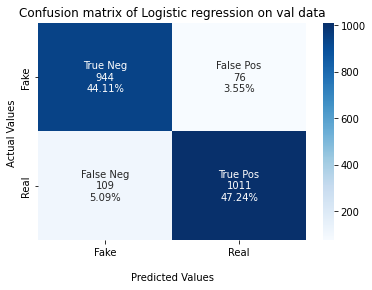

In [ ]:
# Logistic Regression pipeline is fit on covid train preprocessed data 
fit = logistic_pipeline.fit(covid_train.clean_text, covid_train.encoded_label)
# Printing Model name and validation results label
print('Model LogisticRegression')
print ('Validation Results:')
# Predicting using validation data by the trained model 
pred = logistic_pipeline.predict(covid_valid.clean_text)
# Calling classification report function print_metrics
print_metrices(pred, covid_valid.encoded_label)
print('------------------------------------------------------')
# Confusion matrix 
cf_matrix = confusion_matrix(covid_valid.encoded_label,pred)
# Calling confusion matrix using function plot_confusion_matrix
plot_confusion_matrix(cf_matrix, title = 'Confusion matrix of Logistic regression on val data')

Model LogisticRegression
Test Results:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1020
           1       0.96      0.88      0.92      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140

------------------------------------------------------
Accuracy :  0.9163551401869159
Precison :  0.919957369630095
Recall :  0.9163551401869159
F1 :  0.9163464644236821
------------------------------------------------------


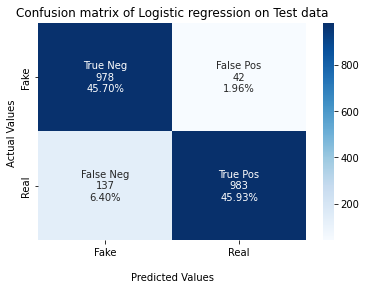

In [ ]:
# Logistic Regression pipeline is fit on covid train preprocessed data 
fit = logistic_pipeline.fit(covid_train.clean_text, covid_train.encoded_label)
# Printing Model name and test results label
print('Model LogisticRegression')
print ('Test Results:')
# Predicting using test data by the trained model 
pred = logistic_pipeline.predict(covid_test_labelled.tweet)
# Calling classification report function print_metrics
print_metrices(pred, covid_test_labelled.encoded_label)
print('------------------------------------------------------')
# confusion matrix
cf_matrix = confusion_matrix(covid_test_labelled.encoded_label,pred)
# Calling confusion matrix using function plot_confusion_matrix
plot_confusion_matrix(cf_matrix, title = 'Confusion matrix of Logistic regression on Test data')

# Decision Tree

In the below pipeline we are passing Count Vectorizer and TF-idf vectorizer for performing Decision Tree Model

In [ ]:
# We are passing countvectorizer and tfidf followed by Decision Tree in the pipeline
decision_pipeline = Pipeline([
        ("Count_vectorizer", CountVectorizer()),
        ("tfidf_vectorizer", TfidfTransformer()),  
        ('Decision_Tree', tree.DecisionTreeClassifier())
])

Please find the explanation for below code 

Model Decision Tree
Validation Results:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1020
           1       0.87      0.86      0.86      1120

    accuracy                           0.86      2140
   macro avg       0.86      0.86      0.86      2140
weighted avg       0.86      0.86      0.86      2140

------------------------------------------------------
Accuracy :  0.8556074766355141
Precison :  0.8555992876122411
Recall :  0.8556074766355141
F1 :  0.8555717577298624
------------------------------------------------------


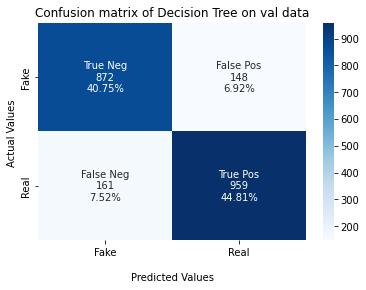

In [ ]:
# Decision Tree pipeline is fit on covid train preprocessed data 
fit = decision_pipeline.fit(covid_train.clean_text, covid_train.encoded_label)
# Printing Model name and valid results label
print('Model Decision Tree')
print ('Validation Results:')
# Predicting using valid data by the trained model 
pred = decision_pipeline.predict(covid_valid.clean_text)
# Calling classification report function print_metrics
print_metrices(pred, covid_valid.encoded_label)
print('------------------------------------------------------')
# Confusion matrix
cf_matrix = confusion_matrix(covid_valid.encoded_label,pred)
# Calling confusion matrix using function plot_confusion_matrix
plot_confusion_matrix(cf_matrix, title = 'Confusion matrix of Decision Tree on val data')

Model Decision Tree
Test Results:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1020
           1       0.87      0.78      0.82      1120

    accuracy                           0.83      2140
   macro avg       0.83      0.83      0.83      2140
weighted avg       0.83      0.83      0.83      2140

------------------------------------------------------
Accuracy :  0.8266355140186916
Precison :  0.8321253992251105
Recall :  0.8266355140186916
F1 :  0.8267317149059895
------------------------------------------------------


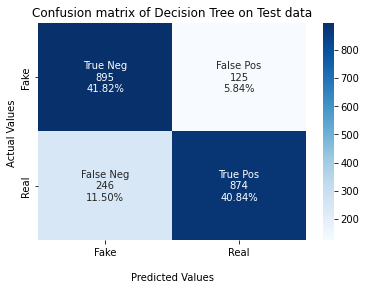

In [ ]:
# Decision Tree pipeline is fit on covid train preprocessed data 
fit = decision_pipeline.fit(covid_train.clean_text, covid_train.encoded_label)
# Printing Model name and test results label
print('Model Decision Tree')
print ('Test Results:')
# Predicting using test data by the trained model 
pred = decision_pipeline.predict(covid_test_labelled.tweet)
# Calling classification report function print_metrics
print_metrices(pred, covid_test_labelled.encoded_label)
print('------------------------------------------------------')
# confusion matrix
cf_matrix = confusion_matrix(covid_test_labelled.encoded_label,pred)
# Calling confusion matrix using function plot_confusion_matrix
plot_confusion_matrix(cf_matrix, title = 'Confusion matrix of Decision Tree on Test data')

# Conclusion

In conclusion we have SVM model with highest accuracy of 93% followed by Logistic regression model of 92% where these are the 2 models which performs well. Also with considering all matrics we have highest performing model as SVM. So, we can use SVM Model to predictt whether the posted tweet is real or fake. Please do find the table below for details

| Model                     | Accuracy | Precision | Recall | F1-Score |
|---------------------------|----------|-----------|--------|----------|
| SVM Model                 | 93       | 93        | 93     | 93       |
| Logistic Regression Model | 92       | 92        | 92     | 92       |
| Decision Tree Model       | 82       | 82        | 82     | 82       |
